# TGFBR1

The TGFBR1 gene encodes a serine/threonine kinase receptor for transforming growth factor-beta (TGFB1; [OMIM:190180](https://omim.org/entry/190181)). Pathogenic variants in TGFBR1 are associated with  two Mendelian diseases, [Loeys-Dietz syndrome 1; OMIM:609192](https://omim.org/entry/609192) and [Multiple self-healing squamous epithelioma, susceptibility to (MSSE); OMIM:132800](https://omim.org/entry/132800) (see below under *Explorative analysis*). This notebook
shows how to perform statistical testing of an hypothesis that was proposed (without formal testing) in a publication which first described
TGFBR1 variants in MSSE.

In [1]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.9.2


## TGFBR1

We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for TGFBR1.

In [2]:
gene_symbol = 'TGFBR1'
mane_tx_id = 'NM_004612.4'
mane_protein_id = 'NP_004603.1' # TGF-beta receptor type-1 isoform 1 precursor [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

phenopacket_store_release = '0.1.23' 
registry = configure_phenopacket_registry()

with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))

cohort_creator = configure_caching_cohort_creator(hpo)
cohort, qc = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)
qc.summarize()

Individuals Processed: 100%|██████████| 41/41 [01:13<00:00,  1.80s/ individuals]
Validated under permissive policy
No errors or warnings were found


In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

n,HPO Term
18,Self-healing squamous epithelioma
18,Scoliosis
15,Hypertelorism
14,Malar flattening
12,Joint hypermobility
12,High palate
12,Dolichocephaly
11,Aortic root aneurysm
11,Dermal translucency
11,Pes planus


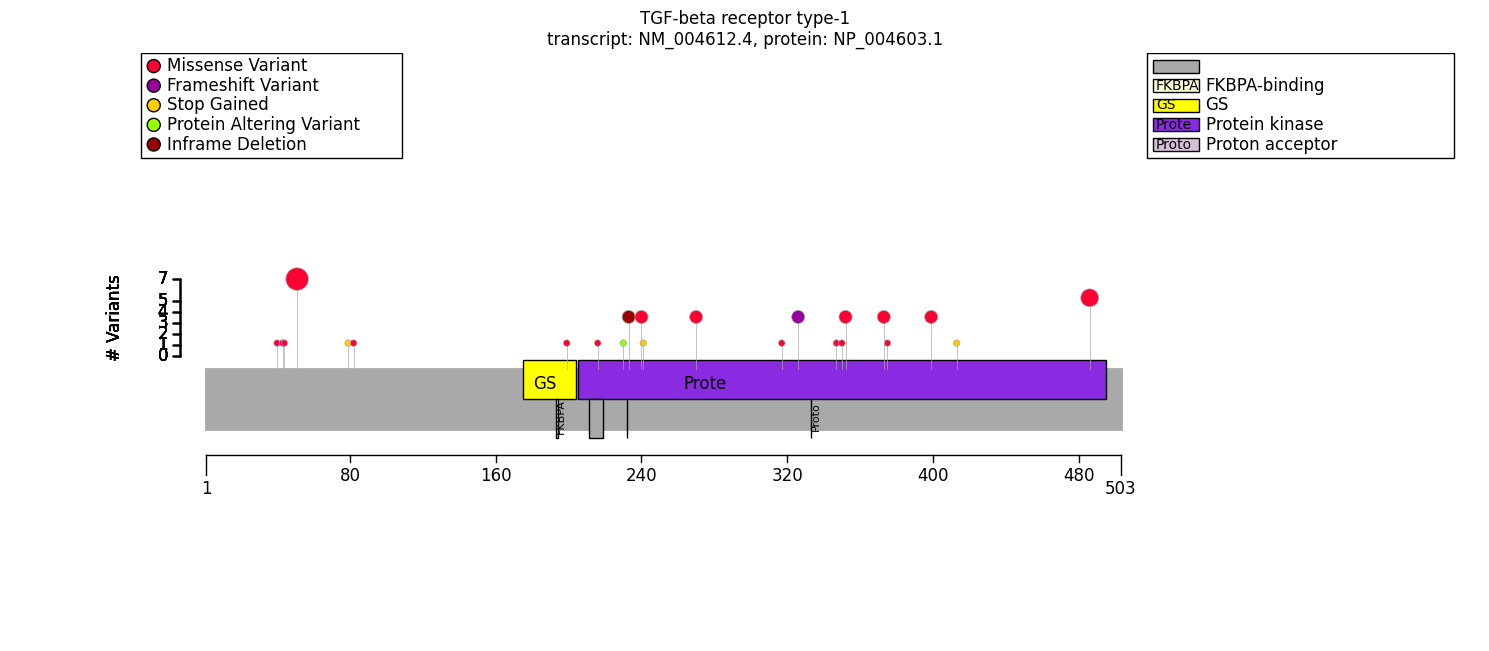

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)
tgfbr1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
tgfbr1_fig.tight_layout()

In [6]:
from gpsea.view import ProteinVariantViewer
pvv = ProteinVariantViewer(protein_metadata=protein_meta, tx_id=mane_tx_id)
pvv.process(cohort=cohort)

Count,Name,Type,Coordinates,Variants
1,GS,Domain,176 - 204,p.Thr200Ile
0,FKBP1A-binding,Motif,194 - 194,
26,Protein kinase,Domain,206 - 495,p.Gly374Arg; p.Met318Arg; p.Arg487Gln; p.Ser236del; p.Leu354AsnfsTer4; p.Arg487Pro; p.Ser241Leu; p.Lys376Glu; p.Asp400Gly; p.Pro327GlnfsTer8; p.Trp242Ter; p.Asp351Val; p.Gly271Asp; p.Gly353Arg; p.Lys232_Ile233del; p.Gly217Val; p.Cys348Tyr; p.Arg414Ter
1,,Binding site,212 - 219,p.Gly217Val
1,,Binding site,233 - 232,p.Lys232_Ile233del
0,Proton acceptor,Active site,334 - 333,


In [7]:
from gpsea.view import CohortVariantViewer
cvv = CohortVariantViewer(tx_id=mane_tx_id)
cvv.process(cohort=cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
7,9_99128911_99128911_G_C,c.154G>C (p.Gly52Arg),2,missense
3,9_99149253_99149253_G_C,c.1460G>C (p.Arg487Pro),9,missense
2,9_99144878_99144878_G_A,c.1120G>A (p.Gly374Arg),6,missense
2,9_99138006_99138006_C_T,c.722C>T (p.Ser241Leu),4,missense
2,9_99144736_99144737_GC_G,c.980del (p.Pro327GlnfsTer8),6,frameshift
2,9_99137985_99137988_TCTC_T,c.705_707del (p.Ser236del),4,inframe deletion
2,9_99142542_99142542_G_A,c.812G>A (p.Gly271Asp),5,missense
2,9_99146553_99146553_A_G,c.1199A>G (p.Asp400Gly),7,missense
1,9_99128891_99128891_A_G,c.134A>G (p.Asn45Ser),2,missense
1,9_99137977_99137983_TAAGATA_C,c.693_699delinsC (p.Lys232_Ile233del),4,protein altering


## Genotype-Phenotype Correlation (GPC) Analysis

In [Goudie et al., 2011](https://pubmed.ncbi.nlm.nih.gov/21358634/), the authors note that all variants found in individuals with MSSE were either missense variants in exon 2 of TGFBR1, encoding part of the extracellular (ligand binding) domain, or were nonsense, splice, or frameshift variants in exons 4, 6 and 7 of the region that encodes the kinase domain. We will therefore create a category of variants (logical disjunction) that comprises either Exon 2 or presumed loss of function variants (nonsense, splice, or frameshift). There does not seem to be a reason to limit the loss of function variants to exons 4,6, and 7 (because, for example, one of the exon 2 variants is presumed loss of function).

We were not able to identify publications that present a statistical analysis of correlations of specific TGFBR1 variants or variant classes with specific phenotypic manifestations. However, pathogenic variants in TGFBR1 are associated with two clinically very different diseases, 
[Loeys-Dietz syndrome 1; OMIM:609192](https://omim.org/entry/609192) and [Multiple self-healing squamous epithelioma, susceptibility to (MSSE); OMIM:132800](https://omim.org/entry/132800). The authors of the first publication about MSSE state:

> The nature of the sequence variants, which include mutations in the extracellular ligand-binding domain and a series of truncating mutations in the kinase domain, indicates a clear genotype-phenotype correlation between loss-of-function TGFBR1 mutations and MSSE ([Goudie et al., 2011](https://pubmed.ncbi.nlm.nih.gov/21358634/)).

Therefore, we will create genotype predicates that encode the corresponding group of variants.

In [8]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest

analysis = configure_hpo_term_analysis(hpo)
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [9]:
from gpsea.model import VariantEffect
from gpsea.view import MtcStatsViewer
from gpsea.analysis.predicate import exon, variant_effect, anyof
from gpsea.analysis.clf import monoallelic_classifier

exon_2_pred = exon(2, mane_tx_id)
frameshift_pred = variant_effect(VariantEffect.FRAMESHIFT_VARIANT, mane_tx_id)
splice_acc_pred = variant_effect(VariantEffect.SPLICE_ACCEPTOR_VARIANT, mane_tx_id)
splice_donor_pred = variant_effect(VariantEffect.SPLICE_DONOR_VARIANT, mane_tx_id)
nonsense_pred = variant_effect(VariantEffect.STOP_GAINED, mane_tx_id)

msse_variant = anyof((exon_2_pred, frameshift_pred, splice_acc_pred, splice_donor_pred, nonsense_pred))

msse_clf = monoallelic_classifier(
    a_predicate=msse_variant,
    b_predicate=~msse_variant,
    a_label="MSSE var",
    b_label="other"
)
msse_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=msse_clf,
    pheno_clfs=pheno_clfs,
)

viewer = MtcStatsViewer()
viewer.process(msse_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,34
HMF03,Skipping term because of a child term with the same individual counts,2
HMF05,Skipping term because one genotype had zero observations,6
HMF08,Skipping general term,62
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,145


In [10]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=msse_result)

Allele group                                       MSSE var          other  \
                                                      Count Percent  Count   
Self-healing squamous epithelioma [HP:0034720]        18/19     95%   0/21   
Hypertelorism [HP:0000316]                             0/18      0%  15/19   
Arterial tortuosity [HP:0005116]                       1/19      5%   8/16   
Abnormal oral cavity morphology [HP:0000163]            1/1    100%  16/16   
Abnormal palate morphology [HP:0000174]                 1/1    100%  16/16   
Abnormal axial skeleton morphology [HP:0009121]         1/1    100%  20/20   
Scoliosis [HP:0002650]                                  1/1    100%  17/20   
Abnormal curvature of the vertebral column [HP:...      1/1    100%  17/17   
Abnormality of the vertebral column [HP:0000925]        1/1    100%  18/18   
Mitral valve prolapse [HP:0001634]                      0/1      0%   8/20   
Mitral regurgitation [HP:0001653]                       0/1      0%   9/21   
Pectus carinatum [HP:0000768]                           0/1      0%   7/17   

Allele group                                                                   \
                                                   Percent Corrected p values   
Self-healing squamous epithelioma [HP:0034720]          0%       2.010932e-09   
Hypertelorism [HP:0000316]                             79%       3.006343e-06   
Arterial tortuosity [HP:0005116]                       50%       1.973435e-02   
Abnormal oral cavity morphology [HP:0000163]          100%       1.000000e+00   
Abnormal palate morphology [HP:0000174]               100%       1.000000e+00   
Abnormal axial skeleton morphology [HP:0009121]       100%       1.000000e+00   
Scoliosis [HP:0002650]                                 85%       1.000000e+00   
Abnormal curvature of the vertebral column [HP:...    100%       1.000000e+00   
Abnormality of the vertebral column [HP:0000925]      100%       1.000000e+00   
Mitral valve prolapse [HP:0001634]                     40%       1.000000e+00   
Mitral regurgitation [HP:0001653]                      43%       1.000000e+00   
Pectus carinatum [HP:0000768]                          41%       1.000000e+00   

Allele group                                                      
                                                        p values  
Self-healing squamous epithelioma [HP:0034720]      1.675777e-10  
Hypertelorism [HP:0000316]                          5.010572e-07  
Arterial tortuosity [HP:0005116]                    4.933586e-03  
Abnormal oral cavity morphology [HP:0000163]        1.000000e+00  
Abnormal palate morphology [HP:0000174]             1.000000e+00  
Abnormal axial skeleton morphology [HP:0009121]     1.000000e+00  
Scoliosis [HP:0002650]                              1.000000e+00  
Abnormal curvature of the vertebral column [HP:...  1.000000e+00  
Abnormality of the vertebral column [HP:0000925]    1.000000e+00  
Mitral valve prolapse [HP:0001634]                  1.000000e+00  
Mitral regurgitation [HP:0001653]                   1.000000e+00  
Pectus carinatum [HP:0000768]                       1.000000e+00

In [11]:
from gpsea.analysis.predicate import variant_key

gly52arg = variant_key("9_99128911_99128911_G_C") # c.154G>C; p.Gly52Arg

gly52arg_clf = monoallelic_classifier(
    a_predicate=gly52arg,
    b_predicate=~gly52arg,
    a_label="Gly52Arg",
    b_label="Other"
)
gly52arg_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=gly52arg_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo=hpo, result=gly52arg_result)

Allele group                                   Gly52Arg          Other  \
                                                  Count Percent  Count   
Self-healing squamous epithelioma [HP:0034720]      7/7    100%  11/33   
Hypertelorism [HP:0000316]                          0/7      0%  15/30   
Neoplasm of the skin [HP:0008069]                   7/7    100%  11/11   

Allele group                                                               \
                                               Percent Corrected p values   
Self-healing squamous epithelioma [HP:0034720]     33%           0.005121   
Hypertelorism [HP:0000316]                         50%           0.041827   
Neoplasm of the skin [HP:0008069]                 100%           1.000000   

Allele group                                              
                                                p values  
Self-healing squamous epithelioma [HP:0034720]  0.001707  
Hypertelorism [HP:0000316]                      0.027885  
Neoplasm of the skin [HP:0008069]               1.000000

In [12]:
from gpsea.analysis.clf import sex_classifier
mf_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=sex_classifier(),
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, mf_result)

Sex                                                FEMALE           MALE  \
                                                    Count Percent  Count   
Arterial tortuosity [HP:0005116]                      1/6     17%   8/11   
Blue sclerae [HP:0000592]                             0/5      0%   6/13   
Disproportionate tall stature [HP:0001519]            1/5     20%   8/12   
Joint hypermobility [HP:0001382]                      2/5     40%  10/14   
Mitral regurgitation [HP:0001653]                     4/7     57%   5/15   
Scoliosis [HP:0002650]                                6/6    100%  12/15   
Hypertelorism [HP:0000316]                            5/5    100%  10/14   
Arachnodactyly [HP:0001166]                           3/5     60%   5/13   
Abnormal oral cavity morphology [HP:0000163]          7/7    100%  10/10   
Abnormal palate morphology [HP:0000174]               7/7    100%  10/10   
Malar flattening [HP:0000272]                         4/6     67%  10/14   
Abnormal axial skeleton morphology [HP:0009121]       6/6    100%  15/15   
Abnormal curvature of the vertebral column [HP:...    6/6    100%  12/12   
Abnormality of the vertebral column [HP:0000925]      6/6    100%  13/13   
Mitral valve prolapse [HP:0001634]                    3/7     43%   5/14   
Pectus carinatum [HP:0000768]                         2/6     33%   5/12   

Sex                                                                            \
                                                   Percent Corrected p values   
Arterial tortuosity [HP:0005116]                       73%           0.699849   
Blue sclerae [HP:0000592]                              46%           0.699849   
Disproportionate tall stature [HP:0001519]             67%           0.699849   
Joint hypermobility [HP:0001382]                       71%           1.000000   
Mitral regurgitation [HP:0001653]                      33%           1.000000   
Scoliosis [HP:0002650]                                 80%           1.000000   
Hypertelorism [HP:0000316]                             71%           1.000000   
Arachnodactyly [HP:0001166]                            38%           1.000000   
Abnormal oral cavity morphology [HP:0000163]          100%           1.000000   
Abnormal palate morphology [HP:0000174]               100%           1.000000   
Malar flattening [HP:0000272]                          71%           1.000000   
Abnormal axial skeleton morphology [HP:0009121]       100%           1.000000   
Abnormal curvature of the vertebral column [HP:...    100%           1.000000   
Abnormality of the vertebral column [HP:0000925]      100%           1.000000   
Mitral valve prolapse [HP:0001634]                     36%           1.000000   
Pectus carinatum [HP:0000768]                          42%           1.000000   

Sex                                                           
                                                    p values  
Arterial tortuosity [HP:0005116]                    0.049774  
Blue sclerae [HP:0000592]                           0.114146  
Disproportionate tall stature [HP:0001519]          0.131222  
Joint hypermobility [HP:0001382]                    0.304696  
Mitral regurgitation [HP:0001653]                   0.376161  
Scoliosis [HP:0002650]                              0.526316  
Hypertelorism [HP:0000316]                          0.530444  
Arachnodactyly [HP:0001166]                         0.607843  
Abnormal oral cavity morphology [HP:0000163]        1.000000  
Abnormal palate morphology [HP:0000174]             1.000000  
Malar flattening [HP:0000272]                       1.000000  
Abnormal axial skeleton morphology [HP:0009121]     1.000000  
Abnormal curvature of the vertebral column [HP:...  1.000000  
Abnormality of the vertebral column [HP:0000925]    1.000000  
Mitral valve prolapse [HP:0001634]                  1.000000  
Pectus carinatum [HP:0000768]                       1.000000

# Summary

In [13]:
from gpseacs.report import GpseaAnalysisReport, GPAnalysisResultSummary

f_results = (
    GPAnalysisResultSummary.from_multi(
        result=msse_result,
        xrefs={
            'HP:0034720': ('PMID:21358634'),
        },
    ),
    GPAnalysisResultSummary.from_mono(
        result=gly52arg_result,

    ),
    GPAnalysisResultSummary.from_mono(
        result=mf_result,

    ),
)

caption = """The nature of the sequence variants, which include mutations in the extracellular ligand-binding domain 
and a series of truncating mutations in the kinase domain, indicates a clear genotype-phenotype correlation between 
loss-of-function TGFBR1 mutations and MSSE \\cite{PMID_21358634}."""
report = GpseaAnalysisReport(name=gene_symbol, 
                             cohort=cohort, 
                             fet_results=f_results,
                             gene_symbol=gene_symbol,
                             mane_tx_id=mane_tx_id,
                             mane_protein_id=mane_protein_id,
                             caption=caption)

In [14]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

In [15]:
summarizer.process_latex(report=report, protein_fig=tgfbr1_fig)

Figure saved to ../../supplement/img/TGFBR1_protein_diagram-draft.pdf
Output to ../../supplement/tex/TGFBR1_summary_draft.tex
